In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 5]


In [2]:
types = ["normal", "natural", "sparse", "triangle", ]
algorithms_gcc = ["eigen", "openmp-cpu", "openmp-offload", "openacc"]
algorithms_nvcc = ["openacc", "cuda", "cublas"]
sizes = [2**x for x in range(1,15)] #2^15 = 16384
compilers = ["gcc-offload", "clang-offload", "nvcc-offload", "gcc-offload-acc", "gcc-offload-dbl", "clang-offload-dbl", "nvcc-offload-dbl", "gcc-offload-acc-dbl"]

In [3]:
file_location = "../results/desy/gcc/"

def process_timings(compiler, method, matrix_type, dbl = False):
    avg_across = []
    for size in sizes:
        avgs = []
        if dbl:
            file = open(file_location + compiler + "-dbl_" + method + "_" + matrix_type + "_" + str(size) + "_double")
        else:
            file = open(file_location + compiler + "_" + method + "_" + matrix_type + "_" + str(size))
        l = 0
        for line in file.readlines():
            if l < 10:
                avgs.append(float(line))
            else:
                break
            l += 1

        avg_across.append(np.mean(np.array(avgs)))
    return avg_across

    
def process_errors(compiler, method, matrix_type, dbl = False):
    err_across = []
    for size in sizes:
        errors = []        
        if dbl:
            file = open(file_location + compiler + "-dbl_" + method + "_" + matrix_type + "_" + str(size) + "_double")
        else:
            file = open(file_location + compiler + "_" + method + "_" + matrix_type + "_" + str(size))
        l = 0
        for line in file.readlines():
            if l > 11:
                errors.append(float(line))
            l += 1
        
        errors.sort()
        err_across.append(np.array(errors))
    return err_across

In [ ]:
ax = plt.subplot()
ax.set_yscale("log")
ax.set_xscale("log")
#for alg in algorithms_gcc:
avg = process_timings("gcc-offload-acc", "openacc", "natural", True)
ax.plot(np.array(sizes), np.array(avg), label=alg+"_Normal")
ax.legend()
ax.grid()

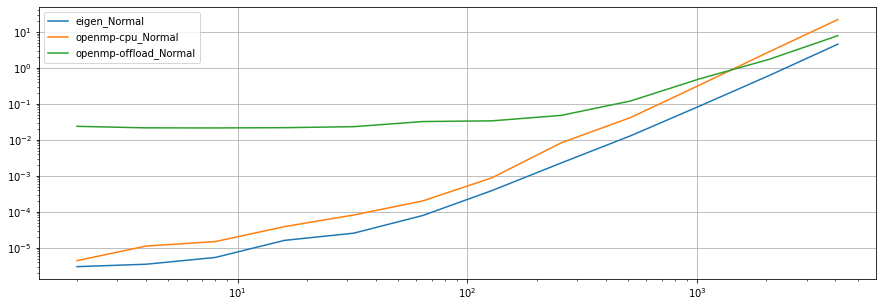

In [39]:
ax = plt.subplot()
ax.set_yscale("log")
ax.set_xscale("log")
for alg in algorithms_gcc:
    if alg == "openacc":
        continue
    avg = process_timings("clang-offload", alg, "normal")
    ax.plot(np.array(sizes), np.array(avg), label=alg+"_Normal")
ax.legend()
ax.grid()

FileNotFoundError: [Errno 2] No such file or directory: './output/nvcc-offload_openacc_normal_2'

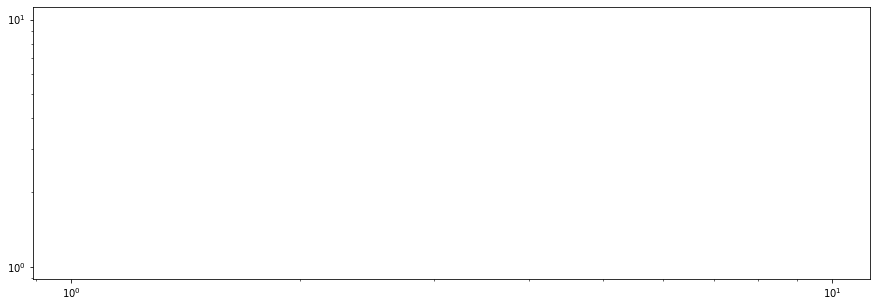

In [40]:
ax = plt.subplot()
ax.set_yscale("log")
ax.set_xscale("log")
for alg in algorithms_nvcc:
    avg = process_timings("nvcc-offload", alg, "normal")
    ax.plot(np.array(sizes), np.array(avg), label=alg+"_Normal")
ax.legend()
ax.grid()

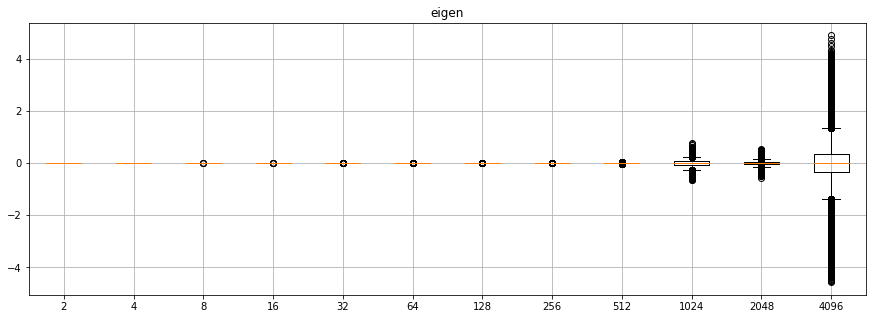

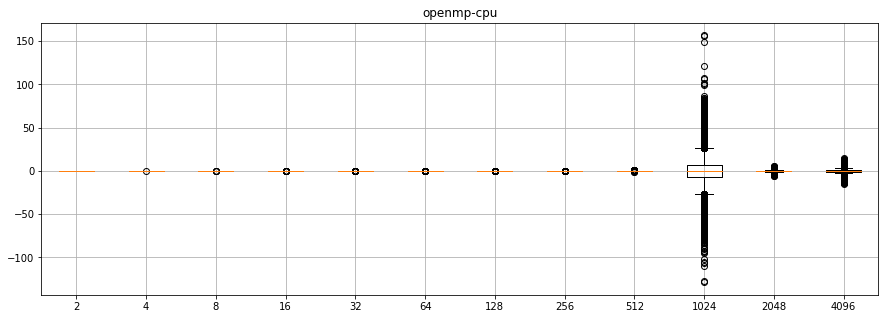

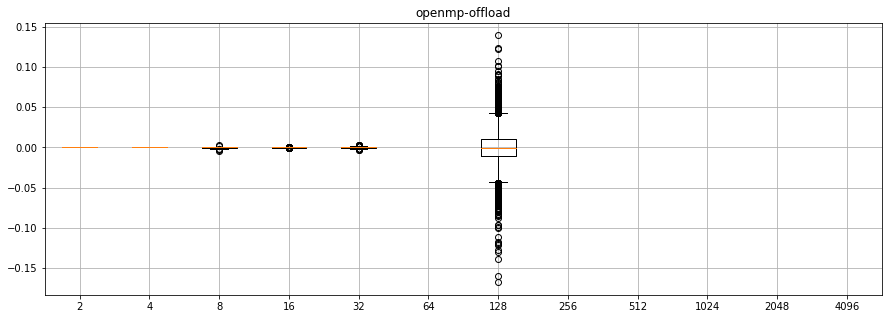

FileNotFoundError: [Errno 2] No such file or directory: './output/gcc-offload_openacc_natural_2'

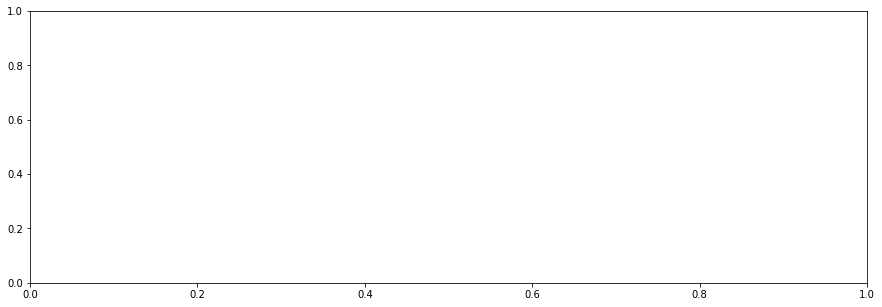

In [6]:
for algorithm in algorithms_gcc:
    ax = plt.subplot()
    errs = process_errors("gcc-offload", algorithm, "natural")
    ax.boxplot(errs)
    ax.grid()
    ax.set_title(algorithm)

    plt.xticks(range(1, len(sizes) + 1), sizes)
    plt.show()

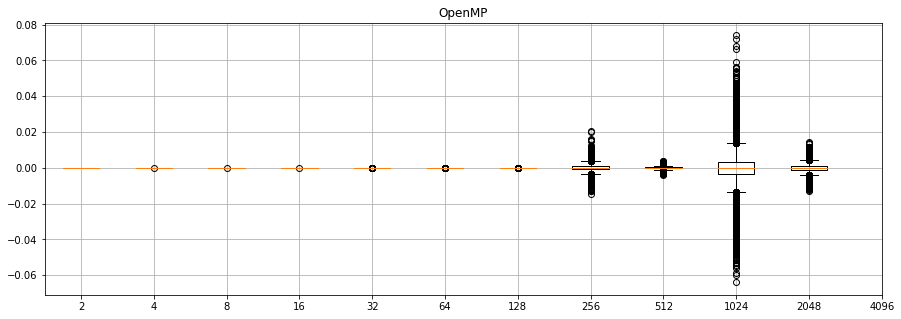

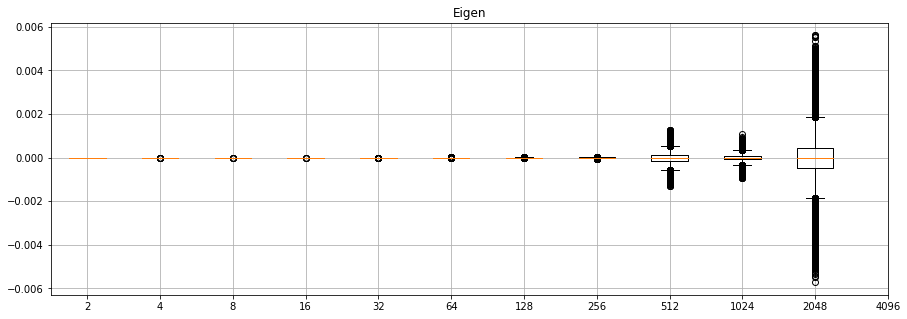

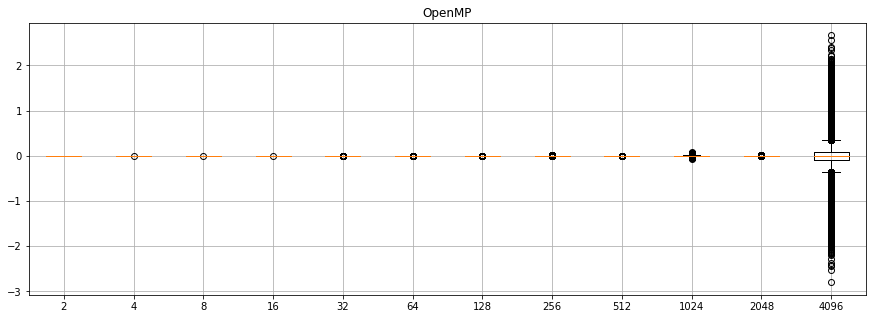

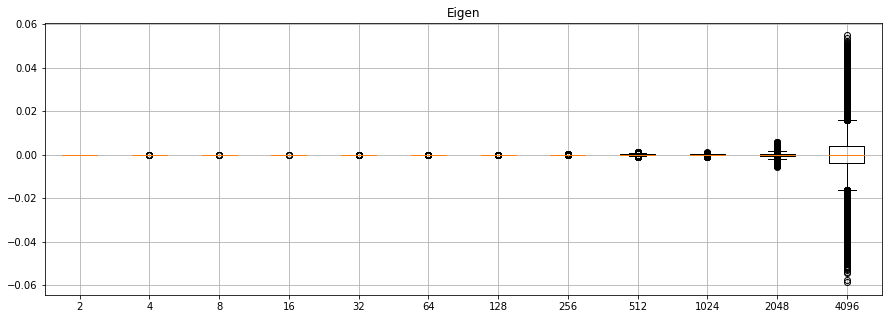

In [5]:
ax = plt.subplot()
errs = process_errors("gcc-offload", "openmp-offload", "normal")
ax.boxplot(errs[:11])
ax.grid()
ax.set_title("OpenMP")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()

ax = plt.subplot()
errs = process_errors("gcc-offload", "eigen", "normal")
ax.boxplot(errs[:11])
ax.grid()
ax.set_title("Eigen")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()


ax = plt.subplot()
errs = process_errors("gcc-offload", "openmp-offload", "normal")
ax.boxplot(errs)
ax.grid()
ax.set_title("OpenMP")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()

ax = plt.subplot()
errs = process_errors("gcc-offload", "eigen", "normal")
ax.boxplot(errs)
ax.grid()
ax.set_title("Eigen")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()

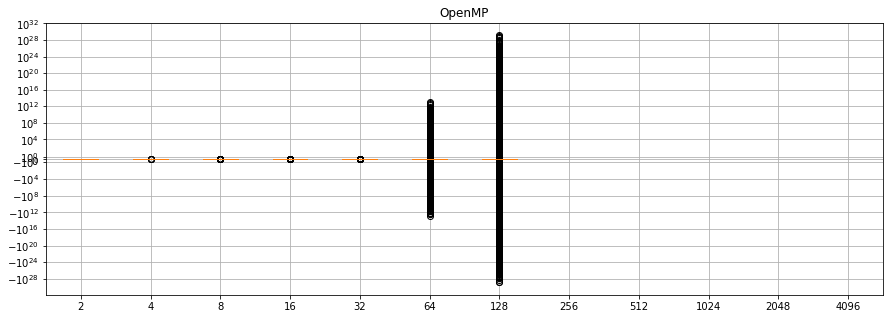

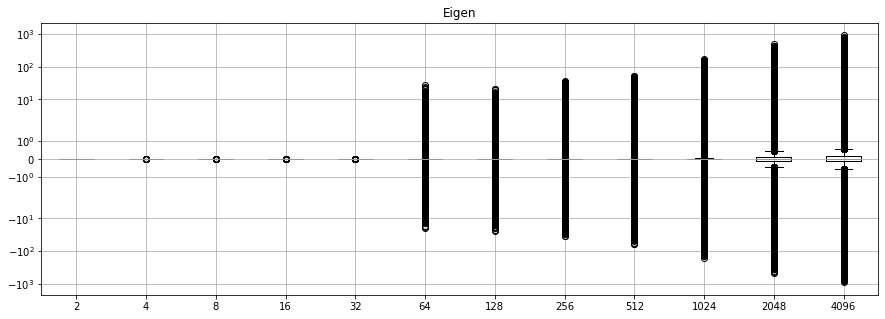

In [9]:
ax = plt.subplot()
errs = process_errors("gcc-offload", "openmp-offload", "triangle")
ax.boxplot(errs)
ax.grid()
ax.set_title("OpenMP")
ax.set_yscale("symlog")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()

ax = plt.subplot()
errs = process_errors("gcc-offload", "eigen", "triangle")
ax.boxplot(errs)
ax.grid()
ax.set_title("Eigen")
ax.set_yscale("symlog")
plt.xticks(range(1, len(sizes) + 1), sizes)
plt.show()